In [ ]:
import numpy as np
import pandas as pd
from util import *
from model import MLPEmbedding
from model import GMF
from evaluate import *
import torch
import torch.nn as nn
from torch import optim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
train_data = pd.read_pickle("../Data/train_data.pkl")
val_data = pd.read_pickle("../Data/val_data.pkl")
test_data = pd.read_pickle("../Data/test_data.pkl")[['review_profilename','beer_name','review_overall']]
test_data = merge_user_id(test_data, on='review_profilename').rename(columns={'id':'user_id'})
test_data = merge_beer_id(test_data, on='beer_name').rename(columns={'id':'beer_id'})[['user_id','beer_id','review_overall']]

In [ ]:
# convert review score to boolean - if the item is relevant to the user (rating >= 3.5) then 1, else 0
threshold = 4.0
train_data['relevant'] = (train_data['review_overall'] >= threshold).astype(int)
train_data.head()

,user_id,beer_id,review_overall,relevant
383941,415,831,3.5,0
483700,2492,3491,4.0,1
375376,1233,1178,4.5,1
705138,1230,902,4.5,1
435972,2290,7497,3.5,0


In [ ]:
### unique users & beers in train_data
n_users = len(train_data['user_id'].unique())
n_beers = len(train_data['beer_id'].unique())
print("unique users: ", n_users)
print("unique beers: ", n_beers)

unique users:  14811
unique beers:  52583


In [ ]:
class NeuMF(nn.Module):
  def __init__(self, gmf_model, mlp_model, n_input, alpha=0.5, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    ## n_input = sum of output shape of the last layer of gmf and mlp model
    super().__init__()
    self.gmf_model=gmf_model
    self.mlp_model=mlp_model
    self.device = device
    print('n_input',n_input)
    self.net = nn.Linear(30, 1).to(self.device) 
    
  
  def forward(self, df):
    # df: user_id, beer_id
#     df = torch.Tensor(df.to_numpy()).to(self.device)
    mlp_out = self.mlp_model.forward(df) # (n,25)
    ## TODO: output of the gmf_model
    gmf_out = self.gmf_model.forward_no_h(df)
#     print('gmf_out.size()', gmf_out.size())
#     print('mlp_out.size()', mlp_out.size())
    input = torch.cat((alpha*mlp_out, (1-alpha)*gmf_out),1).to(self.device)
#     print('input.size()', input.size())
    return self.net(input)

  def predict(self, df):
    return torch.sigmoid(self.forward(df))

  def loss(self, df, loss_fn):
    y_pred = self.forward(df).view(-1)
    y_train = torch.Tensor(df.relevant.to_numpy()).to(self.device)
    
    return loss_fn(y_pred, y_train)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_hidden = 150
epochs = 40
batch_size = 500
lr = 0.01
loss_fn = nn.BCEWithLogitsLoss()
label_pred = 'pred_y'
k=5

In [ ]:
# https://discuss.pytorch.org/t/merging-two-models/45637
gmf_model =  GMF(n_users,n_beers)
gmf_model.load_state_dict(torch.load("../Models/checkpoints/gmf.pth"))
gmf_model.to(device)
mlp_model = MLPEmbedding(n_users=n_users, n_beers=n_beers, device=device, hidden_size=150).to(device)
mlp_model.load_state_dict(torch.load("../Models/checkpoints/mlp_best.pth")['model_state_dict'])
mlp_model.to(device)
# neu_mf_model = NeuMF(gmf_model, mlp_model, n_input, device)
# optimizer = optim.Adam(list(neu_mf_model.gmf_model.parameters()) + list(neu_mf_model.mlp_model.parameters()) + list(neu_mf_model.net.parameters()), lr=1e-4, weight_decay=5e-4)

MLPEmbedding(
  (users_emb): Embedding(14811, 150)
  (beers_emb): Embedding(52583, 150)
  (mlp): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.6, inplace=False)
    (12): Linear(in_features=50, out_features=25, bias=True)
    (13): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.6, inplace=False)
  )
  (last_layer): Linear(in_features=25, out_features=1, bia

In [ ]:
neu_mf_model.device

In [ ]:
import math

# device = gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## model params
mlp_hidden_size = 150
gmf_hidden_size = 5
epochs = 40
batch_size = 500
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
label_pred = 'pred_y'
alpha=0.6
k=5

# n_users, n_beers, mlp_hidden_size, gmf_hidden_size, device
neu_mf_model = NeuMF(gmf_model, mlp_model, mlp_hidden_size, device)
optimizer = optim.Adam(list(neu_mf_model.gmf_model.parameters()) + list(neu_mf_model.mlp_model.parameters()) + list(neu_mf_model.net.parameters()), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [5,10,20], gamma=0.5)

l = []
val_p = []
train_p = []
best_p = 0

for i in range(epochs):
    print("epoch: ",i)
    s = 0
    for bid in range(len(train_data) // batch_size):
        if (bid % 300 == 0):
          print("iteration: ",i, ", batch: ", bid)
        data = train_data[bid * batch_size : (bid + 1) * batch_size]
        optimizer.zero_grad()
        
        loss = neu_mf_model.loss(data, loss_fn)
        loss.backward()
        optimizer.step()
        s += loss
        
    scheduler.step()
    l.append(s.item()/(len(data) // batch_size))  

    # evaluate precision at 10 of the model
  
    neu_mf_model.eval()
    with torch.no_grad():
      val = val_data.copy()
      val[label_pred] = (neu_mf_model.predict(val).cpu().detach().numpy() > 0.5).astype(int)
      val_prec, _ = precision_recall_at_k(val, label_pred=label_pred, threshold=threshold, k=k)
      val_prec = sum(prec for prec in val_prec.values()) / len(val_prec)
      train = train_data.copy()
      train[label_pred] = (neu_mf_model.predict(train).cpu().detach().numpy() > 0.5).astype(int)
      train_prec, _ = precision_recall_at_k(train, label_pred=label_pred, threshold=threshold, k=k)
      train_prec = sum(prec for prec in train_prec.values()) / len(train_prec)

      train_p.append(train_prec)
      val_p.append(val_prec)
    neu_mf_model.train()
    
    print("Train precision at 5: ", train_prec)
    print("Validation precision at 5: ", val_prec)
    print("Current best validation precision at 5: ", best_p)
    if val_prec > best_p:
      print("Validation precision better than best current precision. Saving model to best_state_dict...")
      best_state_dict = {
           'model_state_dict': neu_mf_model.state_dict()
           }
      best_p = val_prec

      
    print("Average Loss for the current iteration: ", l[i])
    print("-----------------------------------")

n_input 150
epoch:  0
iteration:  0 , batch:  0
iteration:  0 , batch:  300
iteration:  0 , batch:  600
iteration:  0 , batch:  900
iteration:  0 , batch:  1200
iteration:  0 , batch:  1500
iteration:  0 , batch:  1800
Train precision at 5:  0.7453514279927166
Validation precision at 5:  0.6907636216325881
Current best validation precision at 5:  0
Validation precision better than best current precision. Saving model to best_state_dict...
Average Loss for the current iteration:  1030.6793212890625
-----------------------------------
epoch:  1
iteration:  1 , batch:  0
iteration:  1 , batch:  300
iteration:  1 , batch:  600
iteration:  1 , batch:  900
iteration:  1 , batch:  1200
iteration:  1 , batch:  1500
iteration:  1 , batch:  1800
Train precision at 5:  0.7655031170526461
Validation precision at 5:  0.6917932617649202
Current best validation precision at 5:  0.6907636216325881
Validation precision better than best current precision. Saving model to best_state_dict...
Average Loss 

iteration:  17 , batch:  300
iteration:  17 , batch:  600
iteration:  17 , batch:  900
iteration:  17 , batch:  1200
iteration:  17 , batch:  1500
iteration:  17 , batch:  1800
Train precision at 5:  0.8540071568428775
Validation precision at 5:  0.6935498390835814
Current best validation precision at 5:  0.6939706974546115
Average Loss for the current iteration:  751.7276611328125
-----------------------------------
epoch:  18
iteration:  18 , batch:  0
iteration:  18 , batch:  300
iteration:  18 , batch:  600
iteration:  18 , batch:  900
iteration:  18 , batch:  1200
iteration:  18 , batch:  1500
iteration:  18 , batch:  1800
Train precision at 5:  0.8545304165822619
Validation precision at 5:  0.6914095379560402
Current best validation precision at 5:  0.6939706974546115
Average Loss for the current iteration:  747.0913696289062
-----------------------------------
epoch:  19
iteration:  19 , batch:  0
iteration:  19 , batch:  300
iteration:  19 , batch:  600
iteration:  19 , batch: 

iteration:  35 , batch:  300
iteration:  35 , batch:  600
iteration:  35 , batch:  900
iteration:  35 , batch:  1200
iteration:  35 , batch:  1500
iteration:  35 , batch:  1800
Train precision at 5:  0.8761888686336622
Validation precision at 5:  0.6920723336259247
Current best validation precision at 5:  0.6945941079828217
Average Loss for the current iteration:  688.4375
-----------------------------------
epoch:  36
iteration:  36 , batch:  0
iteration:  36 , batch:  300
iteration:  36 , batch:  600
iteration:  36 , batch:  900
iteration:  36 , batch:  1200
iteration:  36 , batch:  1500
iteration:  36 , batch:  1800
Train precision at 5:  0.8746832309319547
Validation precision at 5:  0.6931908716494646
Current best validation precision at 5:  0.6945941079828217
Average Loss for the current iteration:  688.0029296875
-----------------------------------
epoch:  37
iteration:  37 , batch:  0
iteration:  37 , batch:  300
iteration:  37 , batch:  600
iteration:  37 , batch:  900
iterati

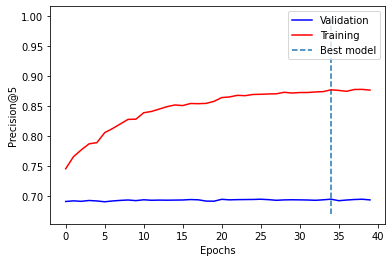

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_p, color='b', label='Validation')
plt.plot(train_p, color='r', label='Training')
plt.vlines(np.argmax(val_p),0.67,1.0, linestyles='dashed', label='Best model')
plt.ylabel('Precision@5')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
## n_users=14811
## n_beers=52583
## device:gpu
hidden_size=150
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model = NeuMF(gmf_model, mlp_model, hidden_size, device)
torch.save(best_state_dict, "../Models/checkpoints/neu_mf.pth")
# best_model.load_state_dict(best_state_dict['model_state_dict'])

n_input 150


In [ ]:
#label_pred = 'pred_y'
best_model.to(device)
best_model.eval()
test_data[label_pred] = (best_model.predict(test_data)>0.5).cpu().detach().numpy().astype(int)
test_data

,user_id,beer_id,review_overall,pred_y
0,0,5892,4.0,1
1,2,5892,4.0,1
2,9,5892,4.0,1
3,12,5892,4.0,1
4,17,5892,5.0,1
...,...,...,...,...
300822,14731,14334,2.5,0
300823,14776,42943,4.5,0
300824,14780,22042,4.5,0
300825,14785,36467,3.5,0


In [ ]:
#threshold=4
#k=5
test_prec, test_recall = precision_recall_at_k(test_data, label_pred=label_pred, threshold=threshold, k=k)
# Precision and recall can then be averaged over all users
print("precision at 5 for test set: ", sum(prec for prec in test_prec.values()) / len(test_prec))
print("recall at 5 for test set:", sum(rec for rec in test_recall.values()) / len(test_prec))

precision at 5 for test set:  0.6406764394604831
recall at 5 for test set: 0.5465328089842406


In [ ]:
best_model.eval()
val_data[label_pred] = (best_model.predict(val_data)>0.5).cpu().detach().numpy().astype(int)
val_prec, val_recall = precision_recall_at_k(val_data, label_pred=label_pred, threshold=threshold, k=k)
# Precision and recall can then be averaged over all users
print("precision at 5 for validation set: ", sum(prec for prec in val_prec.values()) / len(val_prec))
print("recall at 5 for validation set:", sum(rec for rec in val_recall.values()) / len(val_prec))

precision at 5 for validation set:  0.6554148943353072
recall at 5 for validation set: 0.5729507226299717


In [ ]:
precisions, recalls = precision_recall_at_k(test_data[test_data['user_id']==0], label_pred=label_pred, threshold=threshold, k=k)
print("precision at 5 for user 0: ", sum(prec for prec in precisions.values()) / len(precisions))
print("recall at 5 for user 0:", sum(rec for rec in recalls.values()) / len(recalls))

precision at 5 for user 0:  0.4
recall at 5 for user 0: 0.0034602076124567475
